In [43]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from glob import glob
import pandas as pd
from copy import deepcopy
from hydra import initialize, compose
import itertools
from phrosty import plotting
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util

In [2]:
pickled_lens_list = os.path.join(config.machine.dir_01, '01_hlwas_sim_detectable_lens_list.pkl')
lens_list = util.unpickle_all(config.machine.dir_02, 'lens_with_subhalos_')

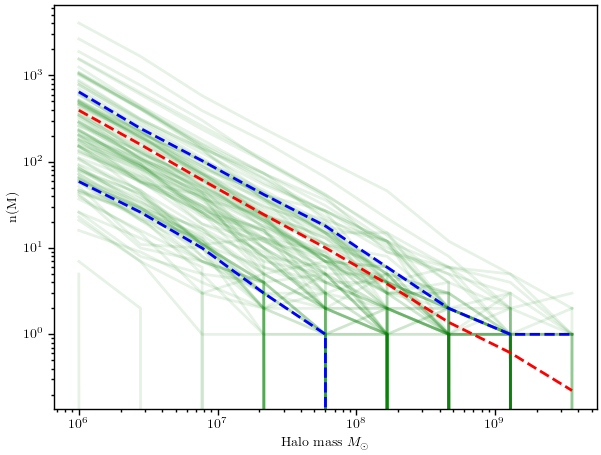

In [25]:
fig = plt.figure(1)
ax = plt.subplot(111)

n_list = []

for lens in lens_list:
    cdm_halo_masses = [halo.mass for halo in lens.realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
    n_list.append(N)
    ax.loglog(m[0:-1], N, alpha=0.1, color='g')

m_mean = np.mean(n_list, axis=0)
# m_median = np.median(m_list, axis=0)
percentile = np.percentile(n_list, [16, 84], axis=0)
ax.loglog(m[0:-1], m_mean, color='r', linestyle='--')
for each in percentile:
    ax.loglog(m[0:-1], each, color='b', linestyle='--')

ax.set_xlabel('Halo mass '+r'$M_{\odot}$')
ax.set_ylabel('n(M)')

plt.show()

In [32]:
print(lens.kwargs_source_dict['F106'])

{'magnitude': 20.173523862996426, 'R_sersic': 0.375194590346169, 'n_sersic': 1.0, 'e1': -0.01697485551773656, 'e2': 0.11832444140308082, 'center_x': 0.2906941372838145, 'center_y': 0.053420562766609045}


In [48]:
lenses_to_check = set()

for lens in tqdm(lens_list):
    sorted_halos = sorted(lens.realization.halos, key=lambda x: x.mass, reverse=True)

    # get image position
    source_x = lens.kwargs_source_dict['F106']['center_x']
    source_y = lens.kwargs_source_dict['F106']['center_y']
    solver = LensEquationSolver(lens.lens_model_class)
    image_x, image_y = solver.image_position_from_source(sourcePos_x=source_x, sourcePos_y=source_y, kwargs_lens=lens.kwargs_lens)

    for halo in sorted_halos:
        if halo.mass < 1e8:
            break
        
        # calculate distances
        for x, y in zip(image_x, image_y):
            dist = np.sqrt(np.power(halo.x - x, 2) + np.power(halo.y - y, 2))

            # check if halo is within 0.1 arcsec of the image
            if dist < 0.1:
                lenses_to_check.add((lens, halo))

print(f'Found {len(lenses_to_check)} lenses to check')

100%|██████████| 103/103 [04:29<00:00,  2.62s/it]

Found 2 lenses to check


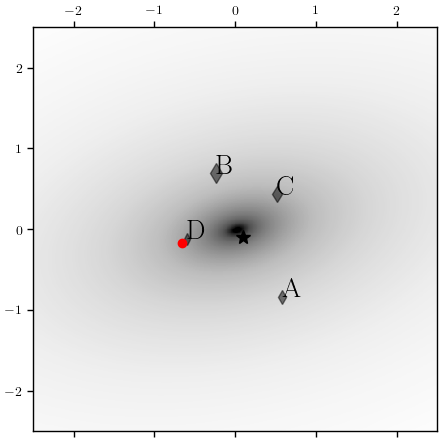

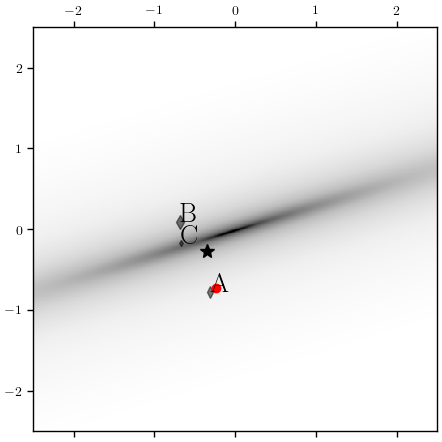

In [56]:
from lenstronomy.Plots import lens_plot

for lens, halo in lenses_to_check:
    ax = plt.subplot(111)
    lens_plot.lens_model_plot(ax, lensModel=lens.lens_model_class, kwargs_lens=lens.kwargs_lens, sourcePos_x=lens.kwargs_source_dict['F106']['center_x'], sourcePos_y=lens.kwargs_source_dict['F106']['center_y'], point_source=True, with_caustics=False, coord_inverse=False)
    ax.plot(halo.x, halo.y, 'ro')
    plt.show()